# 농구선수의 게임 데이터를 활용한 포지션 예측

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#문제-정의" data-toc-modified-id="문제-정의-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>문제 정의</a></span></li><li><span><a href="#데이터-가져오기" data-toc-modified-id="데이터-가져오기-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>데이터 가져오기</a></span></li><li><span><a href="#데이터-시각화" data-toc-modified-id="데이터-시각화-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>데이터 시각화</a></span></li><li><span><a href="#데이터-다듬기" data-toc-modified-id="데이터-다듬기-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>데이터 다듬기</a></span></li><li><span><a href="#데이터-나누기" data-toc-modified-id="데이터-나누기-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>데이터 나누기</a></span></li><li><span><a href="#최적의-kNN-파라미터-찾기" data-toc-modified-id="최적의-kNN-파라미터-찾기-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>최적의 kNN 파라미터 찾기</a></span></li><li><span><a href="#모델-테스트" data-toc-modified-id="모델-테스트-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>모델 테스트</a></span></li></ul></div>

## 문제 정의

NBA 농구선수들의 게임 기록을 데이터로 사용해서 특정 농구선수의 포지션을 예측해보자.

## 데이터 가져오기

2017년 NBA 농구선수의 실제 데이터를 사용한다. 데이터는 2017년도 NBA 선수 게임 통계에서 수집했다.

+ https://www.basketball-reference.com/leagues/NBA_2017_per_game.html

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 사이킷런의 train_test_split을 사용하면 코드 한 줄로 손쉽게 데이터를 나눌 수 있다.
from sklearn.model_selection import train_test_split

# kNN 라이브러리 추가
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

In [4]:
# 데이터를 불러오고 샘플을 확인한다.
df = pd.read_csv('data/basketball_stat.csv')
df.head()

,Player,Pos,3P,2P,TRB,AST,STL,BLK
0,Alex Abrines,SG,1.4,0.6,1.3,0.6,0.5,0.1
1,Steven Adams,C,0.0,4.7,7.7,1.1,1.1,1.0
2,Alexis Ajinca,C,0.0,2.3,4.5,0.3,0.5,0.6
3,Chris Andersen,C,0.0,0.8,2.6,0.4,0.4,0.6
4,Will Barton,SG,1.5,3.5,4.3,3.4,0.8,0.5


In [6]:
# 데이터의 컬럼 확인하기
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Player  100 non-null    object 
 1   Pos     100 non-null    object 
 2   3P      100 non-null    float64
 3   2P      100 non-null    float64
 4   TRB     100 non-null    float64
 5   AST     100 non-null    float64
 6   STL     100 non-null    float64
 7   BLK     100 non-null    float64
dtypes: float64(6), object(2)
memory usage: 6.4+ KB


컬럼 정보

+ Player : 선수 이름
+ Pos : 포지션
+ 3P : 한 경기 평균 3점슛 성공 횟수
+ 2P : 한 경기 평균 2점슛 성공 횟수
+ TRB : 한 경기 평균 리바운드 성공 횟수
+ AST : 한 경기 평균 어시스트 성공 횟수
+ STL : 한 경기 평균 스틸 성공 횟수
+ BLK : 한 경기 평균 블로킹 성공 횟수

포지션의 정보는 Pos이므로 분류할 농구선수의 포지션이 무엇인지, 그리고 각 포지션별로 몇 개의 기존 데이터가 있는지 확인해보자

In [5]:
# 현재 데이터에서 포지션의 개수 확인해보기
df['Pos'].value_counts()

C     50
SG    50
Name: Pos, dtype: int64

+ C : 센터
+ SG : 슈팅 가드

50개씩 두 개의 포지션이 있다.

## 데이터 시각화

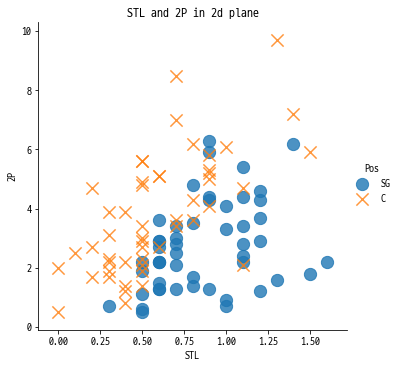

In [6]:
# 스틸, 2점슛 데이터 시각화
sns.lmplot('STL', '2P', data=df, fit_reg=False, # x축, y축, 데이터, 라인 제거
           scatter_kws={'s':150}, # 좌표상 점의 크기
           markers=['o', 'x'], # 마커의 모양
           hue='Pos') # 예측값

# 타이틀
plt.title('STL and 2P in 2d plane')

plt.show()

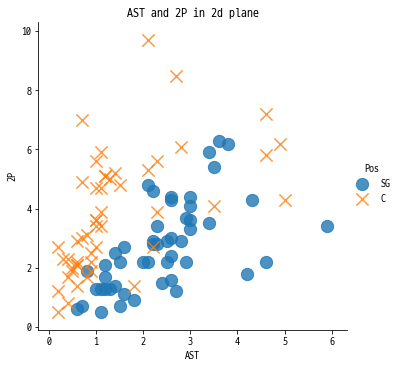

In [7]:
# 어시스트, 2점슛 데이터 시각화
sns.lmplot('AST', '2P', data=df, fit_reg=False, # x축, y축, 데이터, 라인 제거
           scatter_kws={'s':150}, # 좌표상 점의 크기
           markers=['o', 'x'], # 마커의 모양
           hue='Pos') # 예측값

# 타이틀
plt.title('AST and 2P in 2d plane')

plt.show()

2점슛, 어시스트, 스틸의 속성으로 데이터를 분포시킬 경우 가드와 센터의 경계가 너무 근접해서 분류하기에 모호하다.

블로킹과 3점슛 속성으로 시각화 해보기

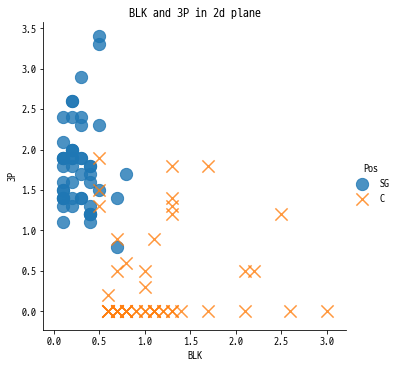

In [8]:
# 블로킹, 3점슛 데이터 시각화
sns.lmplot('BLK', '3P', data=df, fit_reg=False, # x축, y축, 데이터, 라인 제거
           scatter_kws={'s':150}, # 좌표상 점의 크기
           markers=['o', 'x'], # 마커의 모양
           hue='Pos') # 예측값

# 타이틀
plt.title('BLK and 3P in 2d plane')

plt.show()

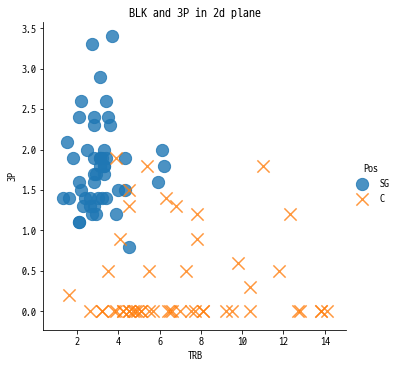

In [9]:
# 리바운드, 3점슛 데이터 시각화
sns.lmplot('TRB', '3P', data=df, fit_reg=False, # x축, y축, 데이터, 라인 제거
           scatter_kws={'s':150}, # 좌표상 점의 크기
           markers=['o', 'x'], # 마커의 모양
           hue='Pos') # 예측값

# 타이틀
plt.title('BLK and 3P in 2d plane')

plt.show()

위에서와는 다르게 같은 분류끼리는 서로 근접해 있고, 다른 분류와는 멀리 떨어져 있는 것을 확인할 수 있다.

시각화를 통해 데이터의 구분이 확실할 경우 선택된 속성들이 머신러닝 정확도에 큰 도움을 줄것이라고 생각할 수 있다.

## 데이터 다듬기

위의 시각화를 이용한 분석을 통해 포지션을 구분해줄 수 있는 속성 외에 불필요한 속성은 삭제해준다.

+ 필요
    + 3P 
    + TRB
    + BLK


+ 불필요
    + 2P
    + AST
    + STL

In [10]:
# 불필요한 속성 삭제하기
df.drop(['2P', 'AST', 'STL'], axis=1, inplace=True)
df.head()

,Player,Pos,3P,TRB,BLK
0,Alex Abrines,SG,1.4,1.3,0.1
1,Steven Adams,C,0.0,7.7,1.0
2,Alexis Ajinca,C,0.0,4.5,0.6
3,Chris Andersen,C,0.0,2.6,0.6
4,Will Barton,SG,1.5,4.3,0.5


## 데이터 나누기

머신러닝 모델을 학습할 데이터와 테스트할 데이터로 현재의 데이터를 나눈다.

사이킷런의 train_test_split을 사용하면 간단하게 학습 데이터와 테스트 데이터로 나눌 수 있다.

In [20]:
# 다듬어진 데이터에서 20%를 테스트 데이터로 분류한다.
train, test = train_test_split(df, test_size=0.2)
train.shape[0], test.shape[0]


(80, 20)

80개의 학습 데이터를 사용해 20개 테스트 데이터의 포지션을 예측해보자.

## 최적의 kNN 파라미터 찾기

+ kNN의 조절 가능한 변수는 오직 하나, 이웃의 개수(k)
+ 교차 검증(cross validation)을 통해 최적의 k를 찾는다.
+ 교차 검증은 k-fold 교차 검증이다.
    - k-fold 교차 검증은 기존 데이터를 k개로 나눠서 k번 정확도를 검증하는 방법이다.

In [21]:
# 최적의 k를 찾기 위해 교차 검증을 수행할 k의 범위를 3부터 학습 데이터 절반까지 지정
max_k_range = train.shape[0] // 2
k_list = []
for i in range(3, max_k_range, 2):
    k_list.append(i)
    
cross_validation_scores = []
x_train = train[['3P', 'BLK', 'TRB']]
y_train = train[['Pos']]

# 교차 검증(10-fold)을 각 k를 대상으로 수행해 검증 결과를 저장
for k in k_list:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, x_train, y_train.values.ravel(), cv=10, scoring='accuracy')
    cross_validation_scores.append(scores.mean())
    
cross_validation_scores

[0.9375,
 0.9,
 0.9125,
 0.9125,
 0.8875,
 0.9,
 0.9,
 0.9,
 0.9,
 0.9,
 0.9,
 0.9,
 0.875,
 0.875,
 0.85,
 0.825,
 0.8375,
 0.825,
 0.8125]

시각화로 최적의 k 알아보기

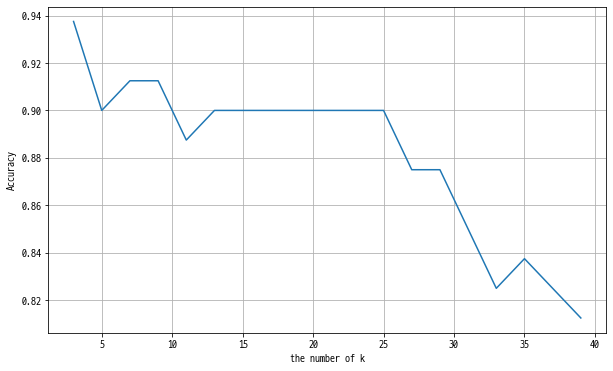

In [22]:
# k에 따른 정확도를 시각화
plt.figure(figsize=(10, 6))
plt.plot(k_list, cross_validation_scores)
plt.xlabel('the number of k')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

시각화를 통해 최적의 k가 3인 것을 알 수 있다. 또 k가 25개를 넘어가면서 정확도가 많이 떨어진다.

In [23]:
# 가장 예측율이 높은 k를 선정
k = k_list[cross_validation_scores.index(max(cross_validation_scores))]
print('The best number of k :', str(k))

The best number of k : 3


## 모델 테스트

분별력이 있다고 판단된 3점슛, 블로킹, 리바운드라는 총 3개의 속성으로 kNN 모델을 학습해보자

In [24]:
knn = KNeighborsClassifier(n_neighbors=3)

# 학습에 사용될 속성을 지정
x_train = train[['3P', 'BLK', 'TRB']]
# 선수 포지션을 예측할 값으로 지정
y_train = train[['Pos']]

# kNN 모델 학습
knn.fit(x_train, y_train.values.ravel())

# 테스트 데이터에서 분류를 위해 사용될 속성을 지정
x_test = test[['3P', 'BLK', 'TRB']]

# 선수 포지션에 대한 정답을 지정
y_test = test[['Pos']]

# 테스트 시작
pred = knn.predict(x_test)

# 모델 예측 정확도(accuracy) 출력
print('accuracy :', str(accuracy_score(y_test.values.ravel(), pred)))

accuracy : 0.9


In [25]:
# 실제값과 예측된 값을 직접 눈으로 비교해보기
comparison = pd.DataFrame({'prediction':pred, 'ground_truth':y_test.values.ravel()})
comparison

,prediction,ground_truth
0,SG,SG
1,SG,SG
2,C,C
3,C,C
4,SG,SG
5,SG,C
6,C,C
7,SG,SG
8,SG,SG
9,SG,SG


+ ground_truth : 실제값
+ prediction : 예측값

> 참고자료

책 : 나의 첫 머신러닝 딥러닝